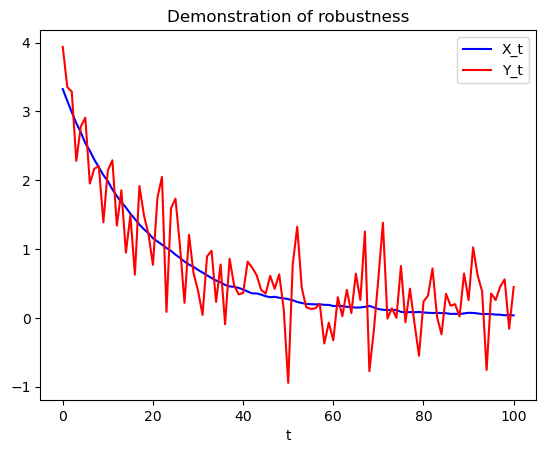

In [1]:
#This file contains illustration in the figures presented in section 5.1 in the paper 
#The code is not our newest version but since the main point here is to demonstrate 
#robustness(no time-comparison is required) all should be fine
import numpy as np
import matplotlib.pyplot as plt
import particles as pc
from scipy.stats import norm
from particles import resampling as rs
import statistics as st
#LG model
T=100
Ns=1000
theta_true=0.95
mu0=3
sigma0=.2
sigmax=0.01
sigmay=0.5
np.random.seed(1)
X_true=[np.random.normal(mu0,sigma0)]
for t in range(T):   
    X_true.append(X_true[-1]*theta_true+np.random.normal(0,sigmax))
Y=X_true+np.random.normal(0,sigmay,T+1)
plt.plot(X_true,color='b',label='X_t')
plt.plot(Y,color='r',label='Y_t')
plt.xlabel("t")
plt.title("Demonstration of robustness")
plt.legend()
c1=.5
A=100
alpha=1
phi0=.8

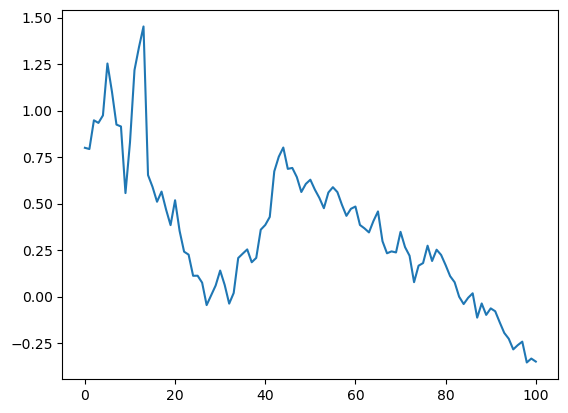

In [2]:
#emperical
#initialisation
#phis=np.array([phi0])
phis=np.array([.8])
np.random.seed(0)
X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
w_tem=w_tem/sum(w_tem)
#l=np.array([sum(phi0* X**2/sigmax**2)/Ns]) 
X=[X[rs.multinomial(w_tem)]]
l=np.array([0]) 
for t in range(T):
    #propagation
    a_t=c1/((t+A+1)**alpha)
    X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
    w_tem=norm(X_tem,sigmay).pdf(Y[t+1])
    X=np.append(X,[X_tem],axis=0)
    X=X[:,rs.multinomial(w_tem/sum(w_tem))]
    matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))
    l=np.append(l,matsum/Ns/sigmax**2)
    #grad=sum((X[-2]+1)*(X[-1]+1-phis[-1]*(X[-2]+1))/sigmax**2*w_tem/np.sum(w_tem))
    grad=l[-1]-l[-2]

    phis=np.append(phis,phis[-1]+a_t*grad)

plt.plot(phis)
phis[-1]
#100,0.55,emperical
phisstore=phis

([<matplotlib.lines.Line2D at 0x218e1bd6610>], 93)

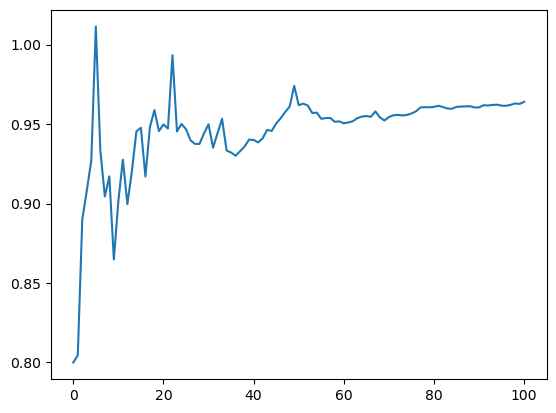

In [3]:
#new
k1=1
ess1=.98
ess2=.95
#initialisation
#phis=np.array([phi0])
phis=np.array([.8])
np.random.seed(1)
X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
w_tem=w_tem/sum(w_tem)
X_old=X
X=[X[rs.multinomial(w_tem)]]
w_tem=np.ones(Ns)/Ns
w_old=w_tem
for t in range(T):
    #propagation
    a_t=c1/((t+A+1)**alpha)
    X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
    w_tem*=norm(X_tem,sigmay).pdf(Y[t+1])
    X=np.append(X,[X_tem],axis=0)
    sum1=sum(np.sum(X[0:t+1]*(X[1:t+2]-phis[-1]*X[0:t+1]),axis=0)/sigmax**2*w_tem/np.sum(w_tem))
    sum2=sum(np.sum(X_old[0:t]*(X_old[1:t+1]-phis[-1]*X_old[0:t]),axis=0)*w_old/np.sum(w_old))/sigmax**2  
    grad=sum1-sum2  
    #print(t,sum1,sum2)
    #lacks term?
    phis=np.append(phis,phis[-1]+a_t*grad)
    a=np.zeros(Ns)
    #questions about phis -2, shouldn't be the last phi for generating SMC?               
    P=norm(phis[-1]*X[0:t,:],sigmax).pdf(X[1:t+1,:])/norm(phis[-2]*X[0:t,:],sigmax).pdf(X[1:t+1,:])               
    a=np.prod(P,axis=0)
    
    if(a[0]>0):
        a/=sum(a)
        cv_a=st.variance(a)/(st.mean(a)**2)
        ess_a=1/(1+cv_a)
        w_tem*=a
        cv_w=st.variance(w_tem)/(st.mean(w_tem)**2)
        ess_w=1/(1+cv_w)
    else:
        ess_a=0
    
    if(ess_a<ess1):
        k1+=1
        X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
        w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
        w_tem=w_tem/sum(w_tem)
        X=[X[rs.multinomial(w_tem)]]
        for t1 in range(t+1):
            X_tem=np.random.normal(phis[-1]*X[-1],sigmax)#bootstrap,q(xt|xt-1,yt)=f(xt|xt-1))
            X=np.append(X,[X_tem],axis=0)
            w_tem*=norm(X_tem,sigmay).pdf(Y[t1+1])
        w_tem=w_tem/sum(w_tem)
        X=X[:,rs.multinomial(w_tem)]   
        w_tem=np.ones(Ns)/Ns
    elif(ess_w<ess2):
        X=X[:,rs.multinomial(w_tem/sum(w_tem))]
        w_tem=np.ones(Ns)
    X_old=X
    w_old=w_tem
plt.plot(phis),k1
#100,0.55,new

Text(0, 0.5, '$\\phi_{t}$')

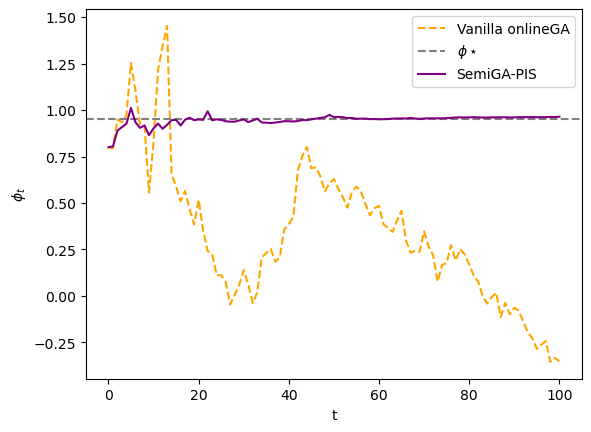

In [4]:
plt.plot(phisstore,color='orange',linestyle='dashed',label='Vanilla onlineGA')
#plt.plot(theta,loglikelihood_true,color='blue',linestyle='dashed',label='true')
plt.axhline(y=0.95, color='gray', linestyle='dashed',label='$\phi\star$')
plt.plot(phis,color='purple',label='SemiGA-PIS')
plt.legend()
plt.xlabel('t')
plt.ylabel('$\phi_{t}$')

In [8]:
#Vanilla GA
S=20
N=1  #repetitions
RMSE=0
F=0
for s in range(S):
    np.random.seed(s)
    phis_all=np.array([phi0])
    for n in range(N):
        phis=np.array([phis_all[-1]])
        X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
        w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
        w_tem=w_tem/sum(w_tem)
        l=np.array([sum(phi0* X**2/sigmax**2)/Ns]) 
        X=[X[rs.multinomial(w_tem)]]
        l=np.array([0]) 
        for t in range(T):
            #propagation
            a_t=c1/((t+A+1)**alpha)
            X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
            w_tem=norm(X_tem,sigmay).pdf(Y[t+1])
            X=np.append(X,[X_tem],axis=0)
            X=X[:,rs.multinomial(w_tem/sum(w_tem))]
            matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))
            l=np.append(l,matsum/Ns/sigmax**2)
            #grad=sum((X[-2]+1)*(X[-1]+1-phis[-1]*(X[-2]+1))/sigmax**2*w_tem/np.sum(w_tem))
            grad=l[-1]-l[-2]
            phis=np.append(phis,phis[-1]+a_t*grad)
        phis_all=np.append(phis_all,phis[1:])
    if(1.3>phis_all[-1]>0.6):    
        RMSE+=(phis_all[-1]-theta_true)**2
    else:
        RMSE+=.35**2
        F+=1
(RMSE/S)**.5,F
    

    

C:\Users\j16577yg\AppData\Local\Temp\ipykernel_9276\3911268426.py:23: RuntimeWarning: invalid value encountered in divide
  X=X[:,rs.multinomial(w_tem/sum(w_tem))]
C:\Users\j16577yg\AppData\Local\Temp\ipykernel_9276\3911268426.py:20: RuntimeWarning: overflow encountered in multiply
  X_tem=np.random.normal(phis[-1]*X[-1],sigmax)
C:\Users\j16577yg\AppData\Local\Temp\ipykernel_9276\3911268426.py:24: RuntimeWarning: overflow encountered in square
  matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))
C:\Users\j16577yg\AppData\Local\Temp\ipykernel_9276\3911268426.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))
C:\Users\j16577yg\AppData\Local\Temp\ipykernel_9276\3911268426.py:24: RuntimeWarning: overflow encountered in multiply
  matsum=np.sum(X[0:t+1]*X[1:t+2])-np.sum(np.dot(phis,X[0:t+1]**2))


(0.32498562384707613, 16)

In [7]:
#SemiGA
S=20
N=1 #repetitions
RMSE=0
F=0
for s in range(S):
    np.random.seed(s)
    phis_all=np.array([phi0])
    for n in range(N):
        phis=np.array([phis_all[-1]])
        #new
        k1=1
        ess1=.98
        ess2=.95
        #initialisation
        #phis=np.array([phi0])
        phis=np.array([.8])
        np.random.seed(1)
        X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
        w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
        w_tem=w_tem/sum(w_tem)
        X_old=X
        X=[X[rs.multinomial(w_tem)]]
        w_tem=np.ones(Ns)/Ns
        w_old=w_tem
        for t in range(T):
            #propagation
            a_t=c1/((t+A+1)**alpha)
            X_tem=np.random.normal(phis[-1]*X[-1],sigmax)    
            w_tem*=norm(X_tem,sigmay).pdf(Y[t+1])
            X=np.append(X,[X_tem],axis=0)
            sum1=sum(np.sum(X[0:t+1]*(X[1:t+2]-phis[-1]*X[0:t+1]),axis=0)/sigmax**2*w_tem/np.sum(w_tem))
            sum2=sum(np.sum(X_old[0:t]*(X_old[1:t+1]-phis[-1]*X_old[0:t]),axis=0)*w_old/np.sum(w_old))/sigmax**2  
            grad=sum1-sum2  
            #print(t,sum1,sum2)
            #lacks term?
            phis=np.append(phis,phis[-1]+a_t*grad)
            a=np.zeros(Ns)
            #questions about phis -2, shouldn't be the last phi for generating SMC?               
            P=norm(phis[-1]*X[0:t,:],sigmax).pdf(X[1:t+1,:])/norm(phis[-2]*X[0:t,:],sigmax).pdf(X[1:t+1,:])               
            a=np.prod(P,axis=0)

            if(a[0]>0):
                a/=sum(a)
                cv_a=st.variance(a)/(st.mean(a)**2)
                ess_a=1/(1+cv_a)
                w_tem*=a
                cv_w=st.variance(w_tem)/(st.mean(w_tem)**2)
                ess_w=1/(1+cv_w)
            else:
                ess_a=0

            if(ess_a<ess1):
                k1+=1
                X=np.random.normal(mu0,sigma0,Ns)  #q(x0|y0=mu(x0))
                w_tem=norm(X,sigmay).pdf(Y[0])#q(y1|x0=1)
                w_tem=w_tem/sum(w_tem)
                X=[X[rs.multinomial(w_tem)]]
                for t1 in range(t+1):
                    X_tem=np.random.normal(phis[-1]*X[-1],sigmax)#bootstrap,q(xt|xt-1,yt)=f(xt|xt-1))
                    X=np.append(X,[X_tem],axis=0)
                    w_tem*=norm(X_tem,sigmay).pdf(Y[t1+1])
                w_tem=w_tem/sum(w_tem)
                X=X[:,rs.multinomial(w_tem)]   
                w_tem=np.ones(Ns)/Ns
            elif(ess_w<ess2):
                X=X[:,rs.multinomial(w_tem/sum(w_tem))]
                w_tem=np.ones(Ns)
            X_old=X
            w_old=w_tem
        #100,0.55,new
        phis_all=np.append(phis_all,phis[1:])
    if(1.3>phis_all[-1]>0.6):    
        RMSE+=(phis_all[-1]-theta_true)**2
    else:
        RMSE+=.35**2
        F+=1
(RMSE/S)**.5,F
    

    

(0.013998502487637675, 0)